一、目前的預處理步驟
資料讀取與整合

讀取 HDF5 檔案： 從 HDF5 檔中讀取每一個 slide 上的 Visium spot 資料。

資料合併： 將各 slide 的資料合併成一個 DataFrame。

欄位篩選： 根據欄位名稱（例如以 "C" 開頭）選取所有代表細胞型表達的欄位。

Log₂ 轉換與 Outlier 處理

Log₂ 轉換： 為了縮放原始數據並處理 0 值，對每個細胞型的表達值進行 log₂(x+1) 轉換。

IQR Outlier 過濾： 計算轉換後數據的第一四分位 (Q1) 與第三四分位 (Q3)，利用 IQR 方法定義合理數值範圍。

極端值替換： 將在 log₂ 轉換後超出 [Q1 - 1.5×IQR, Q3 + 1.5×IQR] 範圍的離群值，替換成該細胞型非離群值的中位數（或選擇平均值）。

結果存放： 每個細胞型經過處理後的數據存放在新的欄位中（例如 "log2_filtered_C1"、"log2_filtered_C2" 等）。

Z-score 標準化

計算統計參數： 針對每一個已經 log₂ 轉換且已處理離群值的細胞型數據，計算其均值和標準差。

標準化： 利用 (value - mean) / std 將數據轉換為標準化數值，這使得各個細胞型的數據有相同的數值尺度。

參數保存： 儲存每個細胞型的均值和標準差（通常存放在一個字典或 JSON 檔中），以便在模型預測後進行反轉標準化還原到原始尺度。

儲存預處理結果

儲存 CSV： 將整個處理後的 DataFrame 存成 CSV 檔，方便後續模型輸入和結果檢查。

儲存參數： 將 Z-score 標準化的統計參數（均值與標準差）存成 JSON 檔，這將作為後續反轉標準化的重要依據。

二、後續該如何進行
模型訓練

使用預處理後數據： 將上述經過 log₂ 轉換、離群值替換並 Z-score 標準化後的數據作為模型的真實標籤，與對應的 HE 影像和空間座標做整合，構建多模態預測模型。

特徵工程： 除了數值標籤外，可能需要從高解析度的 HE 影像中提取特徵（例如用深度學習模型自動學習特徵），並結合 spot 的空間位置，讓模型能夠捕捉到組織的空間結構。

模型預測與結果還原

預測階段： 模型將根據影像與空間特徵預測每個 spot 中各細胞型的 Z-score 標準化後的表達數值。

反轉 Z-score： 利用之前保存的均值和標準差，將模型預測的 Z-score 乘上標準差並加上均值，還原成處理後的 log₂ 表達值。

反轉 Log₂ 轉換： 使用公式 x = 2^(log₂_value) - 1，將 log₂ 表達值進一步還原到原始表達數值。

結果解讀： 這樣的反轉過程能夠讓你將模型的輸出轉換回具有生物學意義的原始尺度，方便後續解釋和應用。

驗證與評估

視覺化檢查： 在模型訓練和預測過程中，利用直方圖、散點圖等方式對反轉後的數據分布進行檢查，確認預處理與反轉步驟的正確性。

統計檢定： 檢查預測結果與真實標籤之間的相關性（例如用 Spearman 排名相關係數評估），確保模型預測能夠準確捕捉到空間細胞型組成的信息。

最終上傳與應用

提交格式： 根據 Challenge 的要求，最終需要提交處理後還原到原始尺度的預測結果，並確保 spot 與細胞型對應正確。

多階段驗證： 在對模型進行調整時，注意在驗證集上進行多次檢查，確保不同 spot 之間的反轉結果連貫且符合生物學預期。

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches

import os
os.chdir("/Users/deweywang/Desktop/GitHub/HEVisum/")

# Training data preparation 

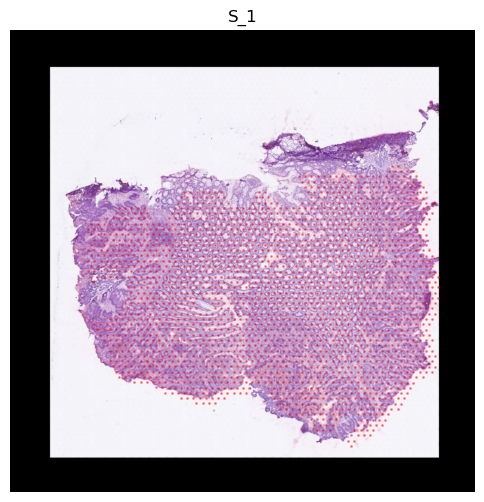

In [32]:
with h5py.File("./dataset/filtered&masked_dataset.h5", "r") as h5file:
    train_images = h5file["images/Train"]
    train_spots = h5file["spots/Train"]
    
    sample = 'S_1'
    image = np.array(train_images[sample])
    spots = np.array(train_spots[sample])
    x, y = spots["x"], spots["y"]
    
    plt.figure(figsize=(6,6))
    plt.imshow(image, aspect="auto")
    plt.scatter(x, y, color="red", s=1, alpha=0.4)
    plt.axis('off')
    plt.title(sample)
    plt.show()

In [77]:

# Load and display (x,y) spot locations and cell type annotation table for Train slides
with h5py.File("./dataset/version-7/no_gu_clip4_processed_train_spots.h5", "r") as f:
    train_spots = f["spots/log2_Train"]
    
    # Dictionary to store DataFrames for each slide
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        # Load dataset as NumPy structured array
        spot_array = np.array(train_spots[slide_name])
        
        # Convert to DataFrame
        df = pd.DataFrame(spot_array)
        
        # Store in dictionary
        train_spot_tables[slide_name] = df
        print(slide_name)

# Example: Display the spots table for slide 'S_1'
train_spot_tables['S_1']

S_1
S_2
S_3
S_4
S_5
S_6


,x,y,zscore_log2_filtered_C1,zscore_log2_filtered_C2,zscore_log2_filtered_C3,zscore_log2_filtered_C4,zscore_log2_filtered_C5,zscore_log2_filtered_C6,zscore_log2_filtered_C7,zscore_log2_filtered_C8,...,zscore_log2_filtered_C26,zscore_log2_filtered_C27,zscore_log2_filtered_C28,zscore_log2_filtered_C29,zscore_log2_filtered_C30,zscore_log2_filtered_C31,zscore_log2_filtered_C32,zscore_log2_filtered_C33,zscore_log2_filtered_C34,zscore_log2_filtered_C35
0,1554,1297,-0.603246,-0.435053,-0.570764,-0.523795,-0.099760,3.204404,-0.510432,0.094953,...,-0.305204,2.848441,1.402928,-0.296408,-0.332695,-0.511507,-0.463607,1.016321,-0.414690,-0.126646
1,462,1502,-0.472097,0.537761,-0.435851,-0.440353,2.367270,-0.435736,0.704734,-0.239895,...,-0.308130,-0.437272,-0.349912,-0.190341,-0.332661,0.804120,0.133164,-0.323027,-0.372806,-0.133392
2,1488,1548,-0.451260,-0.597028,-0.509482,-0.520947,0.435508,-0.426691,-0.606394,-0.269383,...,-0.313622,-0.065456,-0.332085,-0.339042,-0.332745,-0.610033,-0.627723,-0.321262,-0.431268,-0.547821
3,1725,1182,-0.507545,0.783093,-0.465677,-0.498563,3.032796,0.061907,1.986766,-0.084806,...,-0.296417,-0.084218,-0.322369,-0.046703,-0.332668,0.549885,1.008421,-0.326952,-0.408791,0.636778
4,581,1113,-0.457100,-0.369337,-0.452923,-0.431558,1.693930,-0.459043,-0.331140,-0.262851,...,-0.313842,-0.462315,-0.352820,-0.302713,-0.329262,-0.387886,-0.499462,-0.371378,-0.436306,-0.575556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,1055,701,-0.559557,-0.035907,-0.523094,-0.522988,-0.822538,0.859183,-0.051017,-0.025274,...,-0.245349,0.840260,1.853422,0.464063,-0.332718,-0.400502,0.243815,-0.333868,-0.359414,0.773478
2145,1225,862,-0.529086,0.010395,-0.318391,-0.524762,-0.817576,1.381010,-0.164811,-0.196401,...,-0.022436,1.037405,1.027586,0.481288,-0.332743,-0.404575,0.301893,-0.034465,-0.180014,2.424530
2146,765,1479,-0.379121,-0.505304,-0.379173,-0.521146,-0.633435,-0.462212,-0.666774,-0.270042,...,-0.312083,-0.479030,-0.353219,-0.343369,-0.332545,-0.570993,-0.616454,-0.372220,-0.436102,-0.654025
2147,607,1525,-0.618791,0.235444,-0.580484,-0.527196,0.625895,-0.462452,-0.449127,-0.248086,...,-0.301817,-0.468716,-0.331791,0.199688,-0.329564,-0.229333,0.248507,-0.261475,-0.436571,-0.420523


## log 2

In [3]:
import h5py
import numpy as np
import pandas as pd
from scipy.stats import rankdata

# -----------------------------------------------------
# Step 1: 讀取 HDF5 中 Train slide 的 spot 資料，並以 slide 名稱建立 DataFrame 字典
# -----------------------------------------------------
with h5py.File("./dataset/filtered&masked_dataset.h5", "r") as f:
    train_spots = f["spots/Train"]
    
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        spot_array = np.array(train_spots[slide_name])
        df = pd.DataFrame(spot_array)
        df["slide_name"] = slide_name
        train_spot_tables[slide_name] = df
        print(f"✅ 已讀取 slide: {slide_name}")

# -----------------------------------------------------
# Step 2: 合併所有 slide 的資料
# -----------------------------------------------------
all_train_spots_df = pd.concat(train_spot_tables.values(), ignore_index=True)

if "slide_name" not in all_train_spots_df.columns:
    all_train_spots_df["slide_name"] = all_train_spots_df.index.map(lambda i: "unknown")

# -----------------------------------------------------
# Step 3: 對每一個 spot 的 cell abundances 進行排名
# -----------------------------------------------------
cell_type_cols = [col for col in all_train_spots_df.columns if col.startswith("C")]

# 建立一個新的 DataFrame 儲存排名資訊
ranked_df = all_train_spots_df.copy()

# 對每一行做排名（axis=1）
ranked_values = all_train_spots_df[cell_type_cols].apply(
    lambda row: rankdata(row.values, method="ordinal"), axis=1, result_type='expand'
)

# 用原本欄位名稱替代
ranked_values.columns = [f"rank_{col}" for col in cell_type_cols]

# 合併到 ranked_df
ranked_df = pd.concat([ranked_df.drop(columns=cell_type_cols), ranked_values], axis=1)

# -----------------------------------------------------
# Step 4: 顯示排名後的統計描述
# -----------------------------------------------------
print("\n🏁 Ranking done! 每個 cell type 的排名描述:")
print(ranked_df[[col for col in ranked_df.columns if col.startswith("rank_")]].describe())

# ranked_df 現在就可以用來做 Spearman-based 模型訓練 🎯


✅ 已讀取 slide: S_1
✅ 已讀取 slide: S_2
✅ 已讀取 slide: S_3
✅ 已讀取 slide: S_4
✅ 已讀取 slide: S_5
✅ 已讀取 slide: S_6

🏁 Ranking done! 每個 cell type 的排名描述:
           rank_C1      rank_C2      rank_C3      rank_C4      rank_C5  \
count  8181.000000  8181.000000  8181.000000  8181.000000  8181.000000   
mean     26.003789    27.397751    26.416331    17.287740    25.749175   
std       7.823112     3.593320     5.958023    12.164865    11.088218   
min       7.000000    15.000000    10.000000     1.000000     1.000000   
25%      19.000000    24.000000    21.000000     6.000000    18.000000   
50%      27.000000    28.000000    26.000000    14.000000    32.000000   
75%      34.000000    31.000000    33.000000    32.000000    34.000000   
max      35.000000    35.000000    35.000000    35.000000    35.000000   

           rank_C6      rank_C7      rank_C8      rank_C9     rank_C10  ...  \
count  8181.000000  8181.000000  8181.000000  8181.000000  8181.000000  ...   
mean     15.366581    20.154504    1

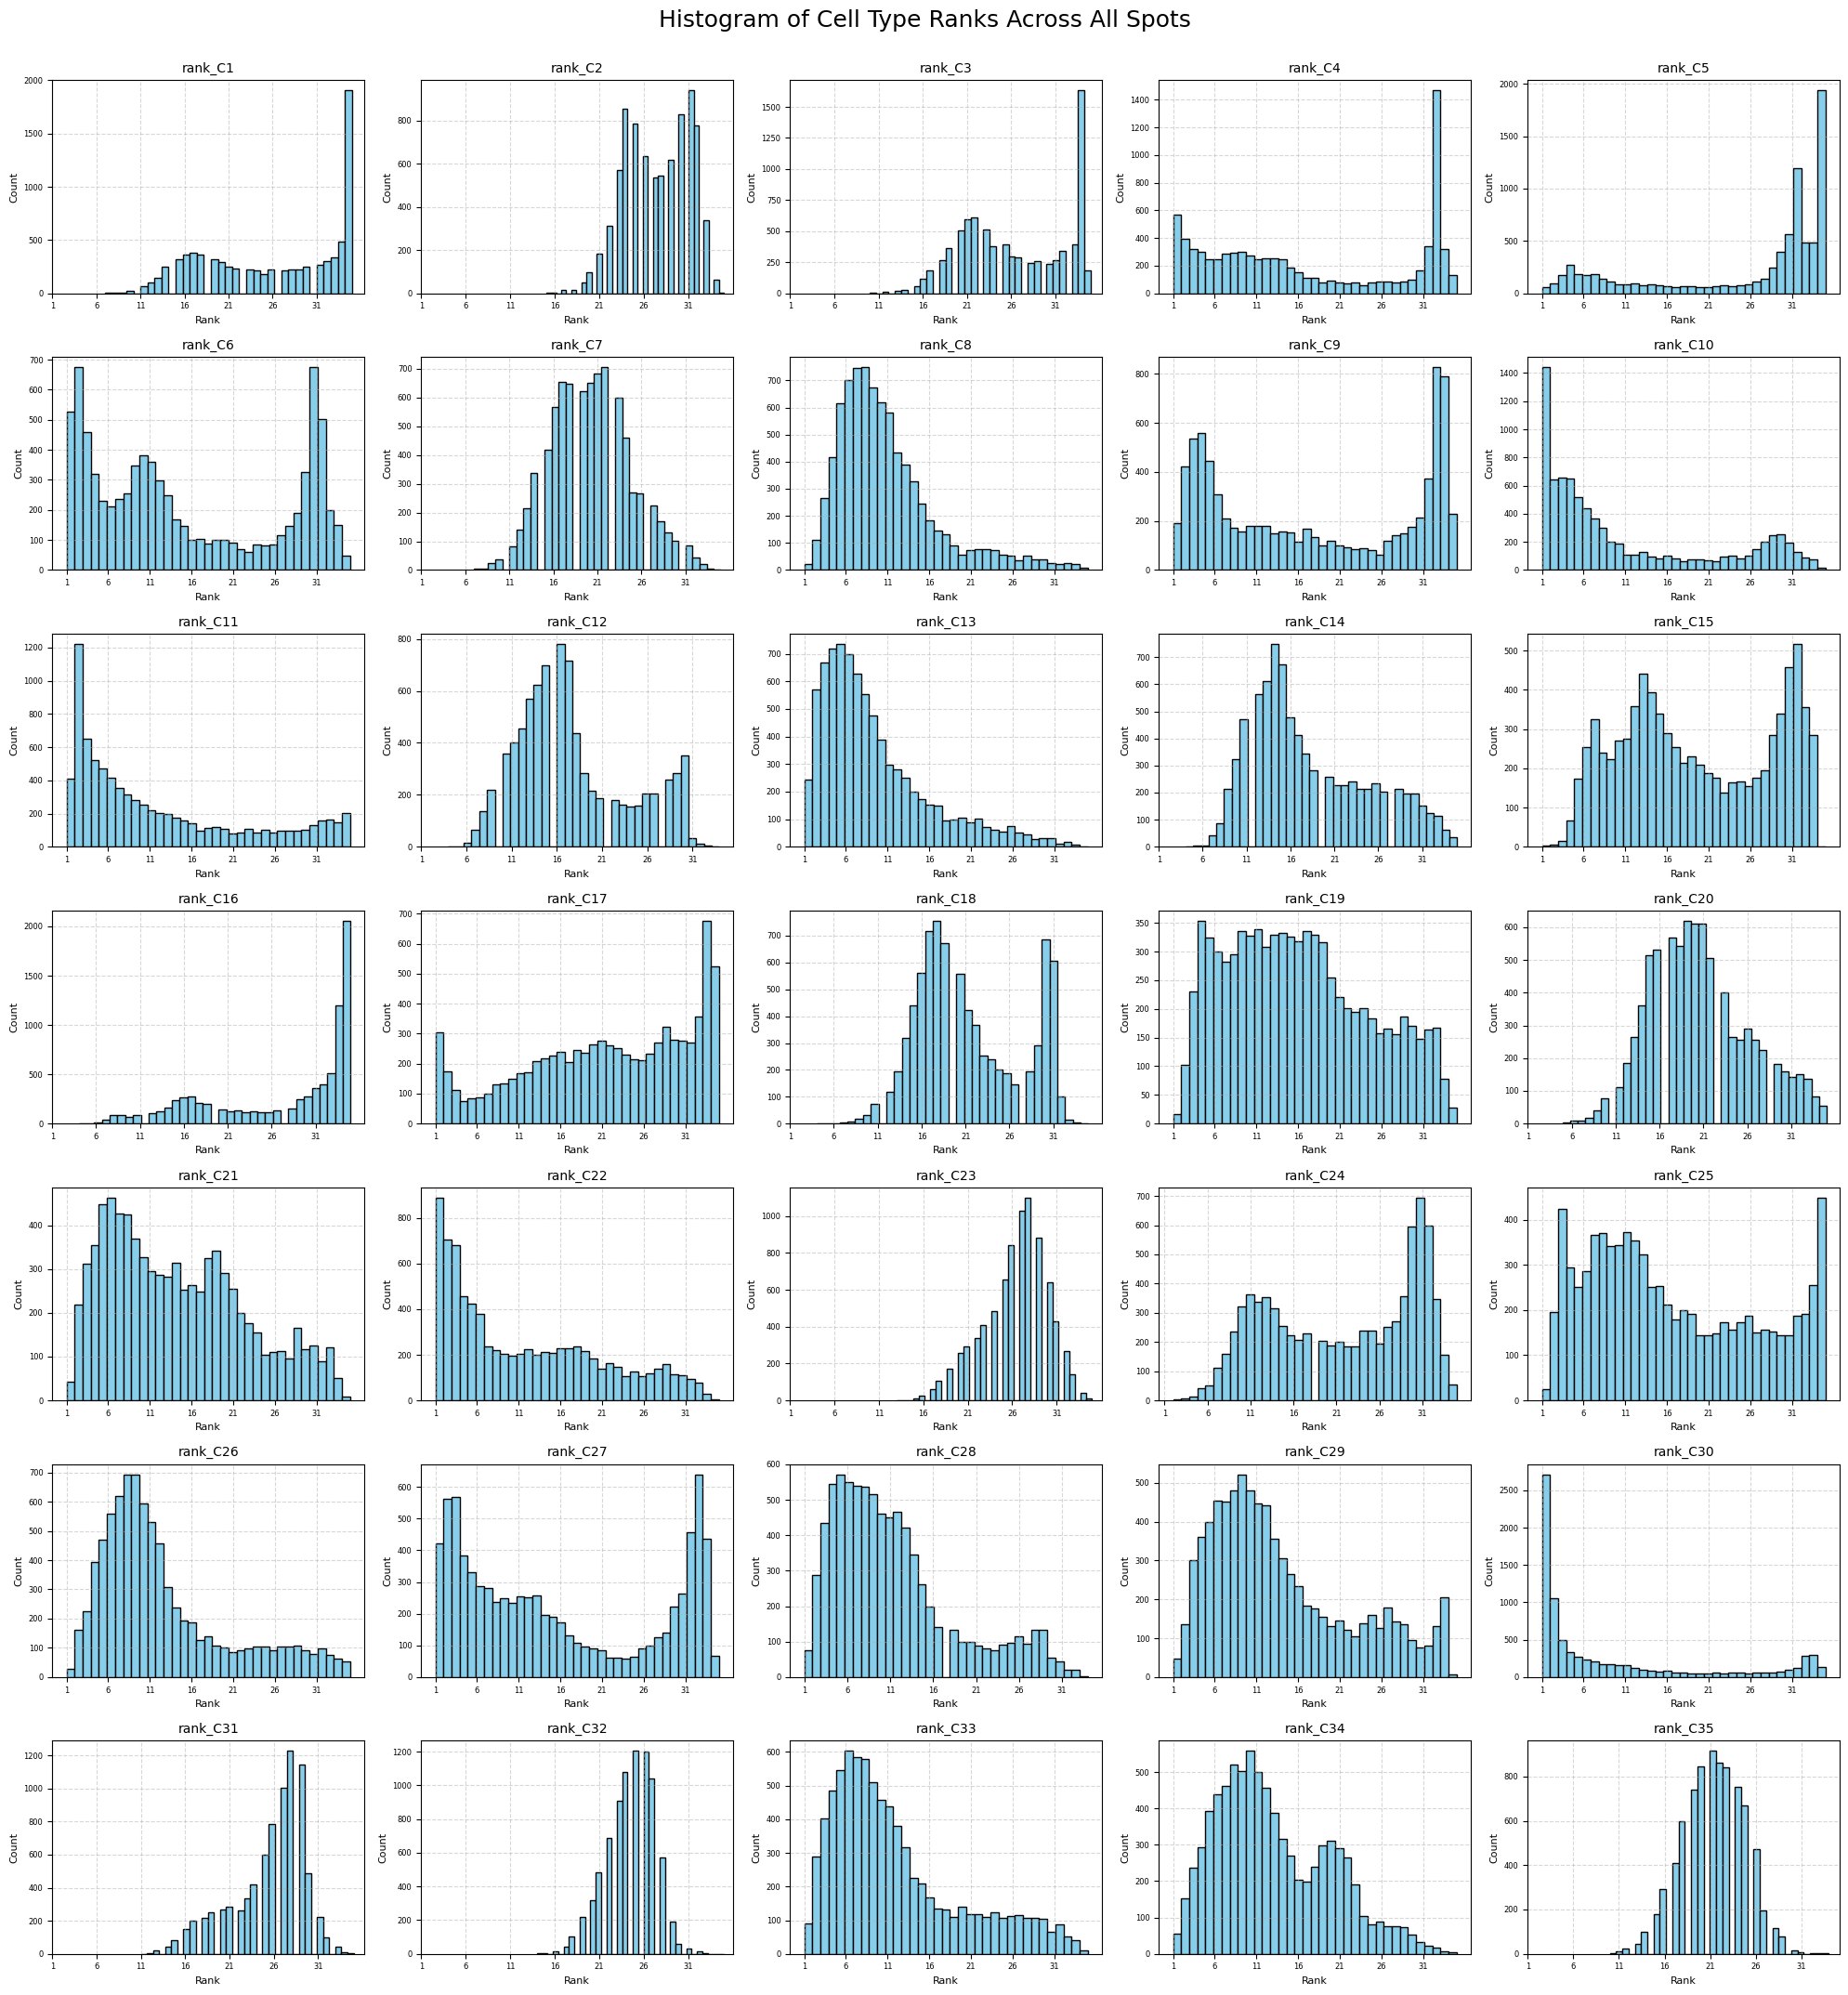

In [8]:
import matplotlib.pyplot as plt
import math

# 所有排名欄位
rank_cols = [col for col in ranked_df.columns if col.startswith("rank_")]
n_plots = len(rank_cols)

# 設定 subplot 的行與列數（例如每列 5 張圖）
n_cols = 5
n_rows = math.ceil(n_plots / n_cols)

# 建立畫布
plt.figure(figsize=(n_cols * 4, n_rows * 3))

for i, col in enumerate(rank_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.hist(ranked_df[col], bins=35, color='skyblue', edgecolor='black')
    plt.title(col, fontsize=10)
    plt.xlabel("Rank", fontsize=8)
    plt.ylabel("Count", fontsize=8)
    plt.xticks(range(1, 36, 5), fontsize=6)
    plt.yticks(fontsize=6)
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("Histogram of Cell Type Ranks Across All Spots", fontsize=18, y=1.02)
plt.show()


## Save data

In [9]:
import h5py
import numpy as np
import pandas as pd

# 假設 filtered_df (包含 slide_name, x, y 與所有 zscore_log2_filtered_{cell} 欄位) 
# 與 cell_type_cols 以及 zscore_params 已經存在

# 例如：
# cell_type_cols = ['C1', 'C2', ..., 'C35']
# zscore_params = {"C1": {"mean": ..., "std": ...}, "C2": {"mean": ..., "std": ...}, ...}
# filtered_df 為預處理後的 DataFrame

# 設定輸出 HDF5 檔案路徑
save_folder = "./dataset/spot-rank/version-1/"
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
output_file = os.path.join(save_folder, "directly_rank_train_spots.h5")

with h5py.File(output_file, "w") as f_out:
    # 建立 group "spots/Train"
    slides_group = f_out.create_group("spots/Train")
    
    # 根據 slide_name 分組，並將每個 slide 的資料存入 dataset
    for slide_name, group_df in ranked_df.groupby("slide_name"):
        # 選擇需要儲存的欄位：x, y 以及所有 zscore_log2_filtered_{cell} 欄位

        cols_to_save = ["x", "y"] + [f"rank_{col}" for col in cell_type_cols]
        # 取出對應的資料
        df_to_save = group_df[cols_to_save].copy()
        
        # 將 DataFrame 轉成 numpy 結構化陣列（不保存 index）
        rec_array = df_to_save.to_records(index=False)
        
        # 存入 group，鍵為 slide_name
        slides_group.create_dataset(slide_name, data=rec_array)
        print(f"Slide {slide_name} 資料已存入 HDF5。")
    print(f"Saved{cols_to_save}")

        
print(f"所有資料與參數已存入 HDF5 檔案：{output_file}")


Slide S_1 資料已存入 HDF5。
Slide S_2 資料已存入 HDF5。
Slide S_3 資料已存入 HDF5。
Slide S_4 資料已存入 HDF5。
Slide S_5 資料已存入 HDF5。
Slide S_6 資料已存入 HDF5。
Saved['x', 'y', 'rank_C1', 'rank_C2', 'rank_C3', 'rank_C4', 'rank_C5', 'rank_C6', 'rank_C7', 'rank_C8', 'rank_C9', 'rank_C10', 'rank_C11', 'rank_C12', 'rank_C13', 'rank_C14', 'rank_C15', 'rank_C16', 'rank_C17', 'rank_C18', 'rank_C19', 'rank_C20', 'rank_C21', 'rank_C22', 'rank_C23', 'rank_C24', 'rank_C25', 'rank_C26', 'rank_C27', 'rank_C28', 'rank_C29', 'rank_C30', 'rank_C31', 'rank_C32', 'rank_C33', 'rank_C34', 'rank_C35']
所有資料與參數已存入 HDF5 檔案：./dataset/spot-rank/version-1/directly_rank_train_spots.h5
